In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas 
from shapely.geometry import Point

from sklearn.impute import SimpleImputer

from datetime import timedelta
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics.cluster import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',500)
pd.set_option('display.max_row',500)

In [2]:
df = pd.read_csv('olist_data.csv')
df.head()

,Unnamed: 0,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_delivered_time,order_estimated_time,difference_time_delivery,review_score,review_creation_date,review_answer_timestamp,review_reaction_time,payment_sequential,payment_type,payment_installments,payment_value,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name_english,customer_unique_id,customer_city,customer_state
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,1.0,credit_card,1.0,18.12,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,3.0,voucher,1.0,2.00,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
2,2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,2.0,voucher,1.0,18.59,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
3,3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,17.858021,5.355729,4.0,2018-08-08 00:00:00,2018-08-08 18:37:50,0.776273,1.0,boleto,1.0,141.46,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,perfumery,af07308b275d755c9edb36a90c618231,barreiras,BA
4,4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,26.628206,17.245498,5.0,2018-08-18 00:00:00,2018-08-22 19:07:58,4.797199,1.0,credit_card,3.0,179.12,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO


In [3]:
# delete Unnamed:0 column
df.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_delivered_time,order_estimated_time,difference_time_delivery,review_score,review_creation_date,review_answer_timestamp,review_reaction_time,payment_sequential,payment_type,payment_installments,payment_value,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name_english,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,1.0,credit_card,1.0,18.12,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,3.0,voucher,1.0,2.00,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.429144,15.536632,7.107488,4.0,2017-10-11 00:00:00,2017-10-12 03:43:48,1.155417,2.0,voucher,1.0,18.59,2017-10-06 11:07:15,29.99,8.72,500.0,19.0,8.0,13.0,1976.0,housewares,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12.502292,17.858021,5.355729,4.0,2018-08-08 00:00:00,2018-08-08 18:37:50,0.776273,1.0,boleto,1.0,141.46,2018-07-30 03:24:27,118.70,22.76,400.0,19.0,13.0,19.0,4693.0,perfumery,af07308b275d755c9edb36a90c618231,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.382708,26.628206,17.245498,5.0,2018-08-18 00:00:00,2018-08-22 19:07:58,4.797199,1.0,credit_card,3.0,179.12,2018-08-13 08:55:23,159.90,19.22,420.0,24.0,19.0,21.0,9576.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO


In [5]:
rec_end = max(df['order_approved_at']) + dt.timedelta(days=1)
rec_end

Timestamp('2018-09-04 17:40:06')

In [6]:
periode = int((max(df['order_approved_at']) - min(df['order_approved_at']))/np.timedelta64(1,'M'))
print("The full period of orders is {} months.".format(periode))

The full period of orders is 23 months.


In [13]:
# 1 year + 6 months before
init_day = rec_end - dt.timedelta(days = 547)
init_day

Timestamp('2017-03-06 17:40:06')

In [14]:
#index copy
df_index = df.copy()
df_index.drop(df_index[df_index['order_approved_at']>init_day].index, inplace=True)

In [15]:
df_index.shape

(3946, 31)

In [16]:
rfm_plus_df = df_index.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

rfm_plus_df.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

rfm_plus_df['Frequency'] = np.log(1 + rfm_plus_df['Frequency'])

rfm_plus_df['Monetary'] = np.log(1 + rfm_plus_df['Monetary'])
    
scaler = StandardScaler()
rfm_plus_normalized = pd.DataFrame(scaler.fit_transform(rfm_plus_df))
rfm_plus_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
#Kmeans
model = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized)

In [17]:
ari_score = []
ari_score.append([0,1])

for d in np.arange(1,78):
    init_day = init_day + dt.timedelta(days = 7)
    
    #create dataset for period
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy['order_approved_at']>init_day].index, inplace=True)
    
    
    
    rfm_plus_df_second = df_copy.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

    rfm_plus_df_second.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

    rfm_plus_df_second['Frequency'] = np.log(1 + rfm_plus_df_second['Frequency'])

    rfm_plus_df_second['Monetary'] = np.log(1 + rfm_plus_df_second['Monetary'])
    
    scaler = StandardScaler()
    rfm_plus_normalized_second = pd.DataFrame(scaler.fit_transform(rfm_plus_df_second))
    rfm_plus_normalized_second.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
    #Kmeans
    model_second = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized_second)
    
    predict = model.predict(rfm_plus_normalized_second)
    
    predict_second = model_second.predict(rfm_plus_normalized_second)
    
    
    #ARI
    ari_p = adjusted_rand_score(predict,predict_second)
    ari_score.append([d,ari_p])

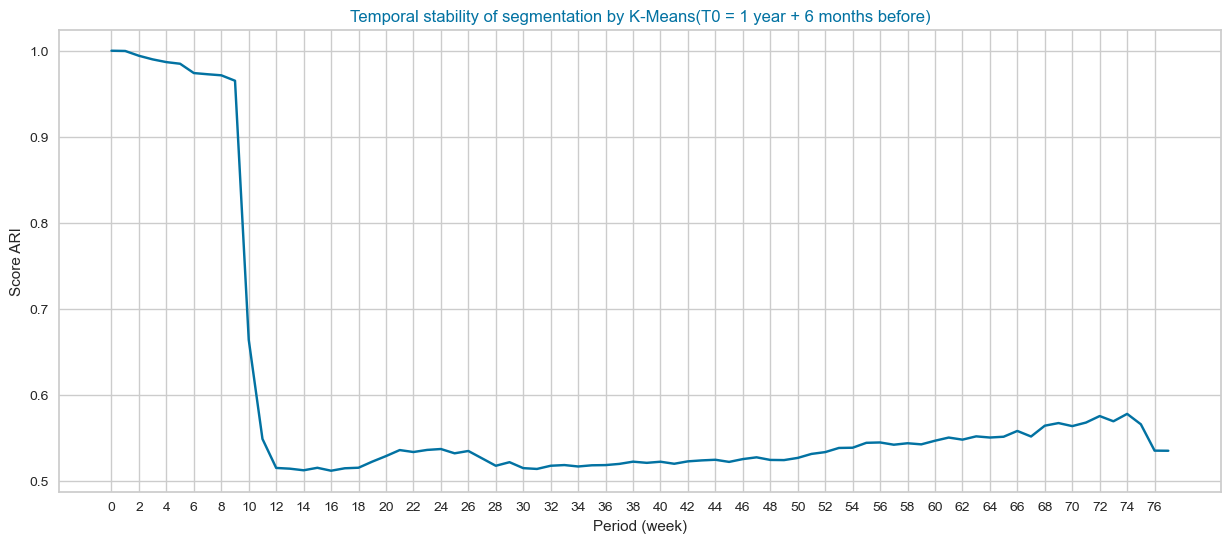

In [19]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 1 year + 6 months before)",
          fontsize=12,
          color="b")
plt.xticks(np.arange(0,78,2))
plt.show()

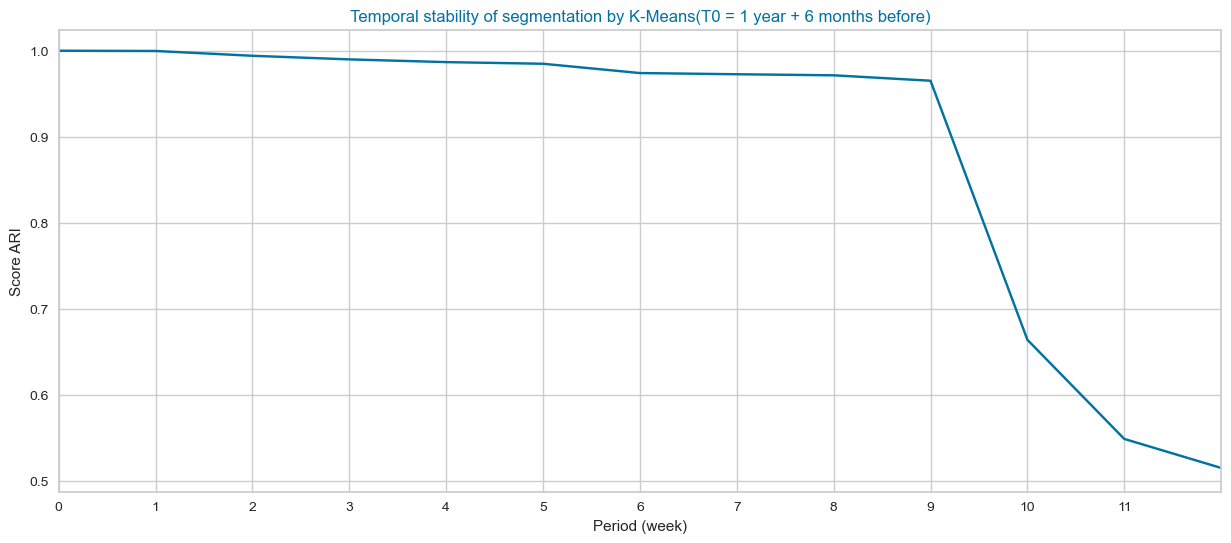

In [21]:
# plot ARI Score
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 1 year + 6 months before)",
          fontsize=12,
          color="b")
plt.xlim([0,12])
plt.xticks(np.arange(0,12))
plt.show()

In [22]:
# 1 year + 3 months before
init_day = rec_end - dt.timedelta(days = 456)
init_day

Timestamp('2017-06-05 17:40:06')

In [23]:
#index copy
df_index = df.copy()
df_index.drop(df_index[df_index['order_approved_at']>init_day].index, inplace=True)

In [24]:
df_index.shape

(14422, 31)

In [25]:
rfm_plus_df = df_index.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

rfm_plus_df.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

rfm_plus_df['Frequency'] = np.log(1 + rfm_plus_df['Frequency'])

rfm_plus_df['Monetary'] = np.log(1 + rfm_plus_df['Monetary'])
    
scaler = StandardScaler()
rfm_plus_normalized = pd.DataFrame(scaler.fit_transform(rfm_plus_df))
rfm_plus_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
#Kmeans
model = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized)


In [26]:
ari_score = []
ari_score.append([0,1])

for d in np.arange(1,65):
    init_day = init_day + dt.timedelta(days = 7)
    
    #create dataset for period
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy['order_approved_at']>init_day].index, inplace=True)
    
    
    
    rfm_plus_df_second = df_copy.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

    rfm_plus_df_second.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

    rfm_plus_df_second['Frequency'] = np.log(1 + rfm_plus_df_second['Frequency'])

    rfm_plus_df_second['Monetary'] = np.log(1 + rfm_plus_df_second['Monetary'])
    
    scaler = StandardScaler()
    rfm_plus_normalized_second = pd.DataFrame(scaler.fit_transform(rfm_plus_df_second))
    rfm_plus_normalized_second.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
    #Kmeans
    model_second = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized_second)
    
    predict = model.predict(rfm_plus_normalized_second)
    
    predict_second = model_second.predict(rfm_plus_normalized_second)
    
    
    #ARI
    ari_p = adjusted_rand_score(predict,predict_second)
    ari_score.append([d,ari_p])
    

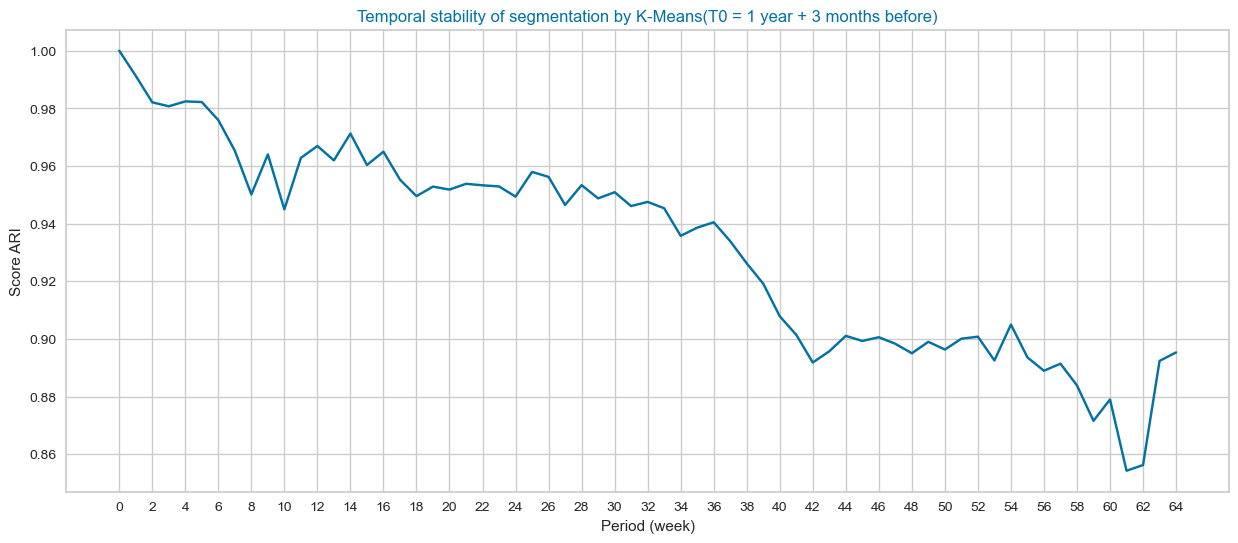

In [27]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 1 year + 3 months before)",
          fontsize=12,
          color="b")
plt.xticks(np.arange(0,65,2))
plt.show()

In [7]:
# 1 year before
init_day = rec_end - dt.timedelta(days = 365)
init_day

Timestamp('2017-09-04 17:40:06')

In [8]:
df.shape

(117741, 31)

In [9]:
#index copy
df_index = df.copy()
df_index.drop(df_index[df_index['order_approved_at']>init_day].index, inplace=True)

In [10]:
df_index.shape

(28188, 31)

In [11]:
rfm_plus_df = df_index.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

rfm_plus_df.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

rfm_plus_df['Frequency'] = np.log(1 + rfm_plus_df['Frequency'])

rfm_plus_df['Monetary'] = np.log(1 + rfm_plus_df['Monetary'])
    
scaler = StandardScaler()
rfm_plus_normalized = pd.DataFrame(scaler.fit_transform(rfm_plus_df))
rfm_plus_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
#Kmeans
model = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized)


In [12]:
ari_score = []
ari_score.append([0,1])

for d in np.arange(1,53):
    init_day = init_day + dt.timedelta(days = 7)
    
    #create dataset for period
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy['order_approved_at']>init_day].index, inplace=True)
    
    
    
    rfm_plus_df_second = df_copy.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

    rfm_plus_df_second.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

    rfm_plus_df_second['Frequency'] = np.log(1 + rfm_plus_df_second['Frequency'])

    rfm_plus_df_second['Monetary'] = np.log(1 + rfm_plus_df_second['Monetary'])
    
    scaler = StandardScaler()
    rfm_plus_normalized_second = pd.DataFrame(scaler.fit_transform(rfm_plus_df_second))
    rfm_plus_normalized_second.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
    #Kmeans
    model_second = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized_second)
    
    predict = model.predict(rfm_plus_normalized_second)
    
    predict_second = model_second.predict(rfm_plus_normalized_second)
    
    
    #ARI
    ari_p = adjusted_rand_score(predict,predict_second)
    ari_score.append([d,ari_p])
    

In [13]:
init_day

Timestamp('2018-09-03 17:40:06')

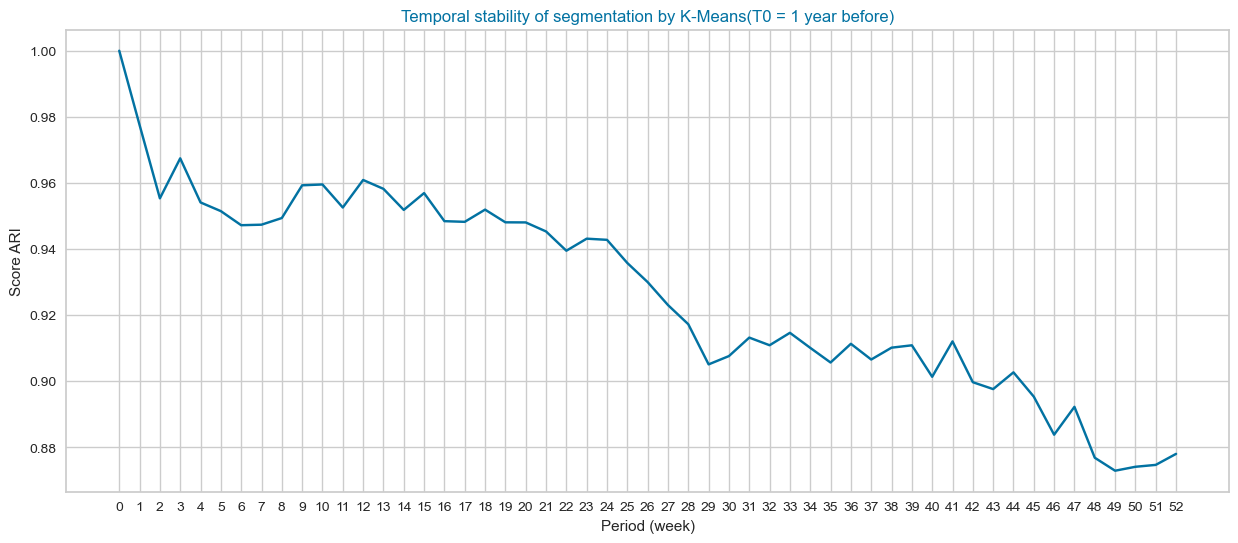

In [14]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 1 year before)",
          fontsize=12,
          color="b")
plt.xticks(np.arange(0,53))
plt.show()

In [22]:
# 6 months before
init_day = rec_end - dt.timedelta(days = 182)
init_day

Timestamp('2018-03-06 17:40:06')

In [23]:
#index copy
df_index = df.copy()
df_index.drop(df_index[df_index['order_approved_at']>init_day].index, inplace=True)

In [24]:
df_index.shape

(72188, 31)

In [25]:
rfm_plus_df = df_index.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

rfm_plus_df.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

rfm_plus_df['Frequency'] = np.log(1 + rfm_plus_df['Frequency'])

rfm_plus_df['Monetary'] = np.log(1 + rfm_plus_df['Monetary'])
    
scaler = StandardScaler()
rfm_plus_normalized = pd.DataFrame(scaler.fit_transform(rfm_plus_df))
rfm_plus_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
#Kmeans
model = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized)

In [26]:
ari_score = []
ari_score.append([0,1])

for d in np.arange(1,25):
    init_day = init_day + dt.timedelta(days = 7)
    
    #create dataset for period
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy['order_approved_at']>init_day].index, inplace=True)
    
    
    
    rfm_plus_df_second = df_copy.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

    rfm_plus_df_second.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

    rfm_plus_df_second['Frequency'] = np.log(1 + rfm_plus_df_second['Frequency'])

    rfm_plus_df_second['Monetary'] = np.log(1 + rfm_plus_df_second['Monetary'])
    
    scaler = StandardScaler()
    rfm_plus_normalized_second = pd.DataFrame(scaler.fit_transform(rfm_plus_df_second))
    rfm_plus_normalized_second.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
    #Kmeans
    model_second = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized_second)
    
    predict = model.predict(rfm_plus_normalized_second)
    
    predict_second = model_second.predict(rfm_plus_normalized_second)
    
    
    #ARI
    ari_p = adjusted_rand_score(predict,predict_second)
    ari_score.append([d,ari_p])
    

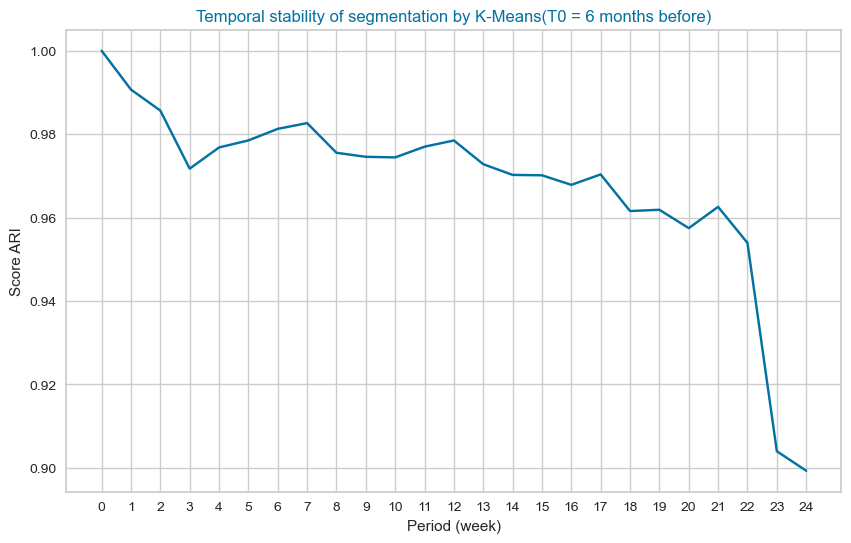

In [28]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 6 months before)",
          fontsize=12,
          color="b")
plt.xticks(np.arange(0,25))
plt.show()

In [33]:
# 3 months before
init_day = rec_end - dt.timedelta(days = 91)
init_day

Timestamp('2018-06-05 17:40:06')

In [34]:
#index copy
df_index = df.copy()
df_index.drop(df_index[df_index['order_approved_at']>init_day].index, inplace=True)

In [35]:
df_index.shape

(96576, 31)

In [36]:
rfm_plus_df = df_index.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

rfm_plus_df.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

rfm_plus_df['Frequency'] = np.log(1 + rfm_plus_df['Frequency'])

rfm_plus_df['Monetary'] = np.log(1 + rfm_plus_df['Monetary'])
    
scaler = StandardScaler()
rfm_plus_normalized = pd.DataFrame(scaler.fit_transform(rfm_plus_df))
rfm_plus_normalized.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
#Kmeans
model = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized)

In [37]:
ari_score = []
ari_score.append([0,1])

for d in np.arange(1,13):
    init_day = init_day + dt.timedelta(days = 7)
    
    #create dataset for period
    df_copy = df.copy()
    df_copy.drop(df_copy[df_copy['order_approved_at']>init_day].index, inplace=True)
    
    
    
    rfm_plus_df_second = df_copy.groupby('customer_id').agg({'order_approved_at': lambda x: (init_day-max(x)).days,
                                       'order_id': 'count',
                                       'payment_value': 'sum',
                                       'review_score': 'mean',
                                       'payment_installments': 'mean'})

    rfm_plus_df_second.columns = ['Recency', 'Frequency', 'Monetary','Review','Installments']

    rfm_plus_df_second['Frequency'] = np.log(1 + rfm_plus_df_second['Frequency'])

    rfm_plus_df_second['Monetary'] = np.log(1 + rfm_plus_df_second['Monetary'])
    
    scaler = StandardScaler()
    rfm_plus_normalized_second = pd.DataFrame(scaler.fit_transform(rfm_plus_df_second))
    rfm_plus_normalized_second.columns = ['n_Recency', 'n_Frequency', 'n_Monetary','n_Review','n_Installments']
    
    #Kmeans
    model_second = KMeans(n_clusters = 5, random_state = 0).fit(rfm_plus_normalized_second)
    
    predict = model.predict(rfm_plus_normalized_second)
    
    predict_second = model_second.predict(rfm_plus_normalized_second)
    
    
    #ARI
    ari_p = adjusted_rand_score(predict,predict_second)
    ari_score.append([d,ari_p])
    

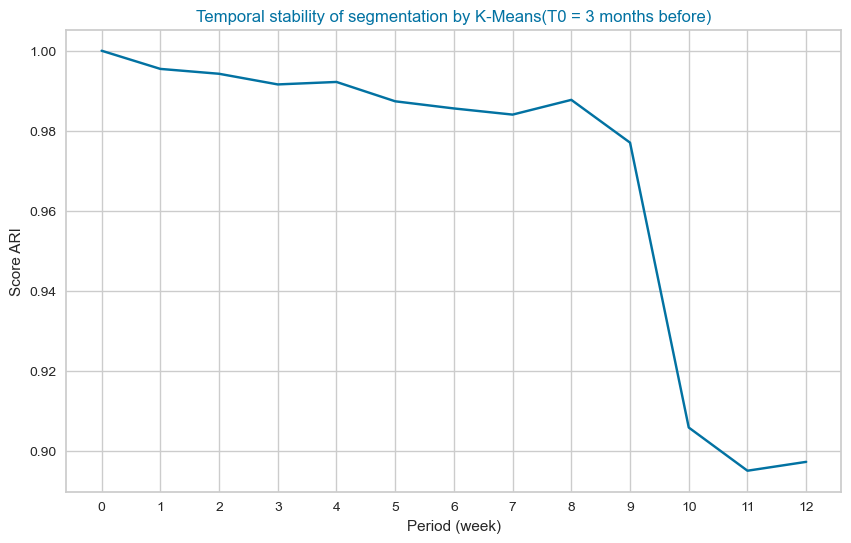

In [38]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.xlabel("Period (week)")
plt.ylabel("Score ARI")
plt.title("Temporal stability of segmentation by K-Means(T0 = 3 months before)",
          fontsize=12,
          color="b")
plt.xticks(np.arange(0,13))
plt.show()

## Conclusion ARI